In [1]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle

2025-09-21 19:13:31.328918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sr = 22050
TOTAL_SAMPLES = 29 * sr

NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [3]:
def augment_audio(slice_song, sr):
    # Time stretching
    stretch_rate = np.random.uniform(0.8, 1.2)
    slice_song_stretched = librosa.effects.time_stretch(slice_song,rate=stretch_rate)

    # Pitch shifting
    pitch_shift = np.random.randint(-2, 3)  # Shift between -2 and +2 semitones
    slice_song_pitched = librosa.effects.pitch_shift(slice_song_stretched, sr=sr, n_steps=pitch_shift)

    # Adding noise
    noise_factor = 0.005
    noise = np.random.randn(len(slice_song_pitched))
    slice_song_noisy = slice_song_pitched + noise_factor * noise

    # Random volume adjustment
    volume_factor = np.random.uniform(0.5, 1.5)
    slice_song_augmented = slice_song_noisy * volume_factor

    return slice_song_augmented

In [4]:
def preprocess_data_MFCC(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Browse each file, slice it and generate the 128 band mfcc for each slice.
    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE

                    slice_song=song[start_sample:end_sample]

                    #augmented_slice=augment_audio(slice_song,sr)

                    # Compute MFCC
                    mfcc = librosa.feature.mfcc(y=slice_song, sr=sr, n_mfcc=128)
                    mfcc = mfcc.T

                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [5]:
def preprocess_data_STFT(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "stft": [] 
        }

    # Browse each file, slice it and generate the 128 band mfcc for each slice.
    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE

                    slice_song=song[start_sample:end_sample]

                    #augmented_slice=augment_audio(slice_song,sr)

                    # Compute STFT
                    stft = np.abs(librosa.stft(slice_song,n_fft=256,hop_length=512))
                    stft = stft.T

                    mydict["labels"].append(i-1)
                    mydict["stft"].append(stft.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [6]:
def load_data_MFCC(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return x, y

In [7]:
def load_data_STFT(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["stft"])
    y = np.array(data["labels"])

    return x, y

In [8]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [154]:
def design_model(input_shape_MFCC, input_shape_STFT):

    # Define the MFCC branch (x1)
    input_MFCC = tf.keras.Input(shape=input_shape_MFCC)
    x1 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu')(input_MFCC)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    #x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    
    #x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)

    #x1 = tf.keras.layers.Conv2D(38, (7, 7), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)

    #x1 = tf.keras.layers.Conv2D(39, (4, 4), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dropout(0.6)(x1)
    
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(200, activation='relu')(x1)
    
    # Define the STFT branch (x2)
    input_STFT = tf.keras.Input(shape=input_shape_STFT)
    x2 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu')(input_STFT)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    #x2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)
    
    #x2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)

    #x2 = tf.keras.layers.Conv2D(57, (6, 6), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)

    #x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.6)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(200, activation='relu')(x2)

    # Concatenate both branches
    merged = tf.keras.layers.Concatenate()([x1, x2])

    # Output layer
    output = tf.keras.layers.Dense(4, activation='softmax')(merged)

    # Create the model
    model = tf.keras.Model(inputs=[input_MFCC, input_STFT], outputs=output)
    
    return model

In [104]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "metal",
        3 : "pop"
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [105]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["acc"], label="train accuracy")
    axs[0].plot(hist.history["val_acc"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [67]:
if not os.path.exists("mfcc.json"):
    preprocess_data_MFCC(source_path="genres_original", json_path="mfcc.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [68]:
if not os.path.exists("stft.json"):
    preprocess_data_STFT(source_path="genres_original", json_path="stft.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [91]:
inputs_MFCC, targets_MFCC = load_data_MFCC(json_path="mfcc.json")

In [92]:
inputs_MFCC.shape

(4000, 125, 128)

In [93]:
inputs_STFT, targets_STFT= load_data_STFT(json_path="stft.json")

In [94]:
inputs_STFT.shape

(4000, 125, 129)

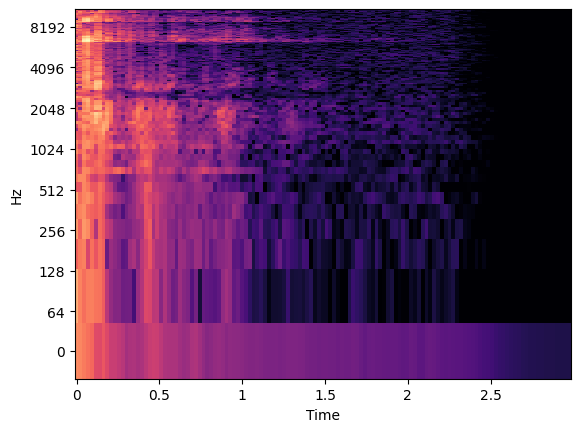

In [95]:
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(inputs_STFT[0],ref=np.max),y_axis="log",x_axis="time",ax=ax)

In [155]:
# Use either targets_STFT or targets_MFCC as the la8,bels (they should be the same)
y = targets_STFT  # Assuming both taprint("File already exists, skipping preprocessing.")rget arrays are identical

# Ensure the labels are one-hot encoded for classification
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_onehot = label_binarizer.fit_transform(y)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
inputs_MFCC_train, inputs_MFCC_val, inputs_STFT_train, inputs_STFT_val, y_train, y_val = train_test_split(
    inputs_MFCC, inputs_STFT, y_onehot, test_size=0.2, random_state=42
)

# Create the model
input_shape_MFCC = (inputs_MFCC_train.shape[1],inputs_MFCC_train.shape[2],1)  # Shape of MFCC input
input_shape_STFT = (inputs_STFT_train.shape[1],inputs_STFT_train.shape[2],1)  # Shape of STFT input
model = design_model(input_shape_MFCC, input_shape_STFT)

model.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics = ['acc']
                     )


In [156]:
model.summary() 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 125, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 125, 129,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 123, 126,  │         40 │ input_layer_24[0… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 123, 127,  │         40 │ input_layer_25[0… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 62, 63, 4) │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 62, 64, 4) │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 63, 4) │         16 │ max_pooling2d_42… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 64, 4) │         16 │ max_pooling2d_43… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 62, 63, 4) │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 62, 64, 4) │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 15624)     │          0 │ dropout_21[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 15872)     │          0 │ dropout_22[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 200)       │  3,125,000 │ flatten_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 200)       │  3,174,600 │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 400)       │          0 │ dense_36[0][0],   │
│ (Concatenate)       │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 4)         │      1,604 │ concatenate_12[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,301,316 (24.04 MB)

 Trainable params: 6,301,300 (24.04 MB)

 Non-trainable params: 16 (64.00 B)

In [157]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                              patience=3)

In [158]:
history = model.fit(
    [inputs_MFCC_train, inputs_STFT_train],  # The two inputs for the model
    y_train,  # The target labels
    validation_data=([inputs_MFCC_val, inputs_STFT_val], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[callback]
    )


Epoch 1/10


2025-09-21 19:49:18.787566: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-21 19:49:18.787592: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-21 19:49:18.971640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1457', 8 bytes spill stores, 8 bytes spill loads

2025-09-21 19:49:19.291915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8422 - loss: 0.8196 - val_acc: 0.8988 - val_loss: 0.3329
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9606 - loss: 0.1148 - val_acc: 0.9737 - val_loss: 0.0912
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9791 - loss: 0.0585 - val_acc: 0.9625 - val_loss: 0.1419
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9850 - loss: 0.0422 - val_acc: 0.9675 - val_loss: 0.0689
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9869 - loss: 0.0336 - val_acc: 0.9762 - val_loss: 0.0750
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9916 - loss: 0.0221 - val_acc: 0.9688 - val_loss: 0.1224
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9909 - loss: 0.0249 - val_acc: 0.9775 - val_loss: 0.0823
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9919 - loss: 0.0217 - val_acc: 0.9688 - val_loss: 0.0927
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9947 

In [159]:
history.history["val_acc"]

[0.8987500071525574,
 0.9737499952316284,
 0.9624999761581421,
 0.9674999713897705,
 0.9762499928474426,
 0.96875,
 0.9775000214576721,
 0.96875,
 0.9737499952316284,
 0.9649999737739563]

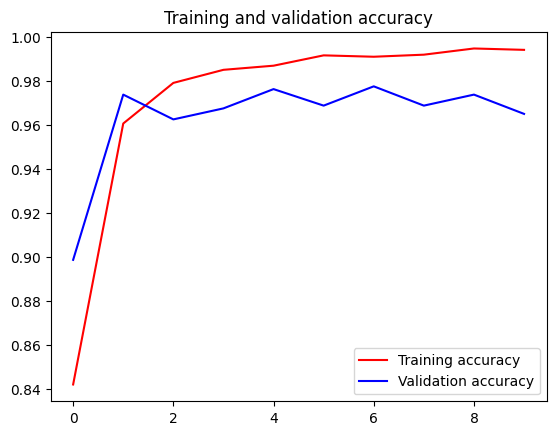

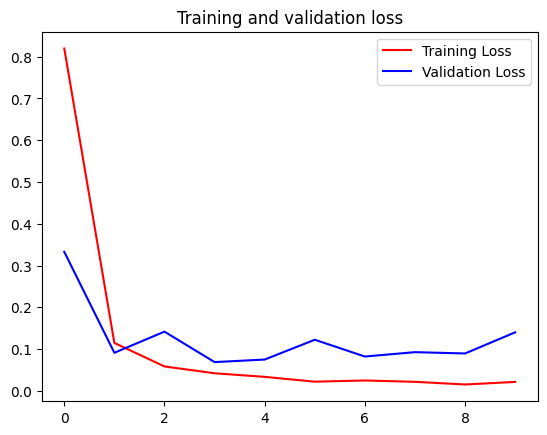

In [160]:
plot_performance(history)

In [161]:
train_accuracy = history.history['acc'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_acc'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Training accuracy: 0.9940624833106995
Test accuracy: 0.9649999737739563


<Figure size 2000x1500 with 0 Axes>

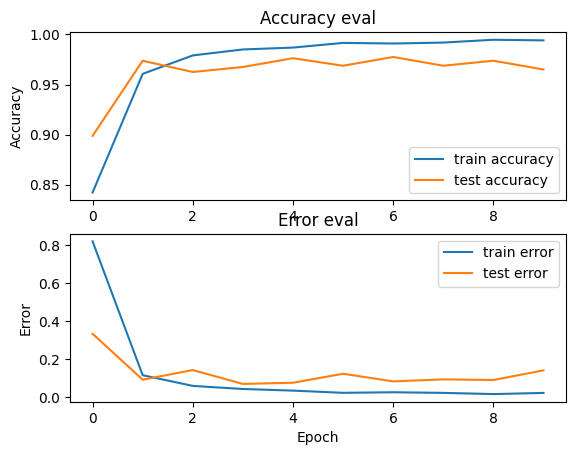

In [162]:
plot_history(history)

In [164]:
# Save the model to a file
with open('CNN14.pkl', 'wb') as file:
    pickle.dump(model, file)